# PM2.5 Prediction Model

## Quick Summary

1. Notebooks named model_1 and model_2 use date_time based time series features (year, month, day, hour, season) as regular features for forecasting: <br>
    * Model_1 uses all the date_time features (year, month, day, hour, season) and meteorological features from the original dataset, the results are not quite satisfying, best performance R2 achieved is around 0.5.
    * Model_ 2 removes the ‘iws’ (cumulated wind speed) column and only keeps the ‘ws’ (hourly wind speed) column, because the numbers in the ‘iws’ column from the original dataset contain periodically reset to zero when wind direction alters, causing undesired artifacts. Therefore, the hourly wind speed ‘ws’ was extracted from the ‘iws’ column during the data wrangling step and it makes better sense to only use the hourly wind speed data ('ws') and drop the ‘iws’ column for modeling. However, all the model performances become slightly worse after dropping the ‘iws’ feature.  
2. Notebooks named moel_3 and model_4 add additional lag features (values at previous steps): <br>
    * Model_3 introduces the lag feature of 1 hour (value from the previous one step), In this case, it’s very useful to include the values at previous time steps for predicting the value for the next step, the R2 scores after adding lag features are boosted to around 0.95. 
    * Model_4 introduces the lag feature of 24 hours (value from the 24 steps back in time, corresponding to the same hour in previous day). The lag feature of 24 hrs is not as helpful as the lag feature of 1hr, but it does help to improve model performance. The lag feature of 24 hrs boosts the R2 metrics to 0.56. 
3. Adding PCA as a preprocessing step in this case:  
    * PCA is helpful in the case of KNeighborsRegressor (kNN) model and MLPRegressor(neutral nets) model
    * PCA shows little difference in linear models (LinearRegression, Lasso and Ridge);
    * PCA shows little difference, if not actually makes it worse, in tree-based models (RandomForestRegressor and GradientBoostingRegressor).
4.	Model comparison:
    * Ranking of feature importance is only possible without using PCA for selective algorithms (LinearRegression, Lasso, Ridge, RandomForestRegressor, GradientBoostingRegressor). For KNeighborsRegressor and MLPRegressor, ranking of feature importance seems impossible (fitting results harder to interpret) 
    * Model performance: Neural network-based algorithms (MLPRegressor) and Tree-based algorithms (RandomForestRegressor and GradientBoostingRegressor) in general give the best performance (R2_score and mean_squared_error), followed by KNeighborsRegressor, followed by linear models (LinearRegression, Lasso and Ridge). But GradientBoostingRegressor takes longer to train because it only works in sequential order; MLPRegressor is harder to design hidden layer structures. 

In [2]:
# import relevant module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler #, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

In [3]:
#import pm_clean from 'pm_clean.csv' file and parse the strings in 'date_time' column into DateTime objects

pm_clean = pd.read_csv('pm_clean.csv',index_col=0, parse_dates=['date_time'])
print(pm_clean.head(1))
print(pm_clean.info())

   year  month  day  hour  season  dewp  humi    pres  temp cbwd   iws  \
0  2010      1    1    23       4 -17.0  41.0  1020.0  -5.0   CV  0.89   

   precipitation  iprec     city  pm_average           date_time    ws  
0            0.0    0.0  beijing       129.0 2010-01-01 23:00:00  0.89  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 168895 entries, 0 to 168894
Data columns (total 17 columns):
year             168895 non-null int64
month            168895 non-null int64
day              168895 non-null int64
hour             168895 non-null int64
season           168895 non-null int64
dewp             168895 non-null float64
humi             168895 non-null float64
pres             168895 non-null float64
temp             168895 non-null float64
cbwd             168895 non-null object
iws              168895 non-null float64
precipitation    168895 non-null float64
iprec            168895 non-null float64
city             168895 non-null object
pm_average       168895 non-null

In [8]:
# use a subset of one city (city Beijing) to explore for now
bj = pm_clean[pm_clean['city'] == 'beijing']

# add lag features by adding the PM value from previous hour
bj['pm_1hr'] = bj['pm_average'].shift(1)
bj.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49853 entries, 1 to 49853
Data columns (total 18 columns):
year             49853 non-null int64
month            49853 non-null int64
day              49853 non-null int64
hour             49853 non-null int64
season           49853 non-null int64
dewp             49853 non-null float64
humi             49853 non-null float64
pres             49853 non-null float64
temp             49853 non-null float64
cbwd             49853 non-null object
iws              49853 non-null float64
precipitation    49853 non-null float64
iprec            49853 non-null float64
city             49853 non-null object
pm_average       49853 non-null float64
date_time        49853 non-null datetime64[ns]
ws               49853 non-null float64
pm_1hr           49853 non-null float64
dtypes: datetime64[ns](1), float64(10), int64(5), object(2)
memory usage: 7.2+ MB


In [80]:
# drop target column 'pm_average' and columns containing irrelevant or duplicated information 'city','date_time' and 'iws'

X = bj.drop(['pm_average','city','date_time','iws'], axis=1)
X = pd.get_dummies(X, drop_first=True)
print(X.info())
print(X.describe())
y = bj['pm_average']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49853 entries, 1 to 49853
Data columns (total 16 columns):
year             49853 non-null int64
month            49853 non-null int64
day              49853 non-null int64
hour             49853 non-null int64
season           49853 non-null int64
dewp             49853 non-null float64
humi             49853 non-null float64
pres             49853 non-null float64
temp             49853 non-null float64
precipitation    49853 non-null float64
iprec            49853 non-null float64
ws               49853 non-null float64
pm_1hr           49853 non-null float64
cbwd_NE          49853 non-null uint8
cbwd_NW          49853 non-null uint8
cbwd_SE          49853 non-null uint8
dtypes: float64(8), int64(5), uint8(3)
memory usage: 5.5 MB
None
               year         month           day          hour        season  \
count  49853.000000  49853.000000  49853.000000  49853.000000  49853.000000   
mean    2012.519628      6.479630     15.688

In [10]:
# train test split by year, using data of year 2010-2014 as training set and data of year 2015 as test set

X_train = X[X['year'] != 2015]
y_train = y[X['year'] != 2015]
print(len(X_train), len(y_train))

X_test = X[X['year'] == 2015]
y_test = y[X['year'] == 2015]
print(len(X_test),len(y_test))

41891 41891
7962 7962


In [11]:
# initialize a score table

index = ['LinearRegression','Lasso','Ridge','RandomForestRegressor','GradientBoostingRegressor','KNeighborsRegressor','MLPRegressor']
score_table = pd.DataFrame(index = index, columns= ['r2_train','r2_test','mse_train','mse_test'])
print(score_table)

                          r2_train r2_test mse_train mse_test
LinearRegression               NaN     NaN       NaN      NaN
Lasso                          NaN     NaN       NaN      NaN
Ridge                          NaN     NaN       NaN      NaN
RandomForestRegressor          NaN     NaN       NaN      NaN
GradientBoostingRegressor      NaN     NaN       NaN      NaN
KNeighborsRegressor            NaN     NaN       NaN      NaN
MLPRegressor                   NaN     NaN       NaN      NaN


### LinearRegression model

In [26]:
# explore with LinearRegression model using default parameters

scaler = StandardScaler()
linreg = LinearRegression()
linreg_1 = Pipeline([('scaler', scaler),('linreg',linreg)])
linreg_1.fit(X_train, y_train)
y_pred_train = linreg_1.predict(X_train)
y_pred_test = linreg_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
feature_rank = pd.DataFrame({'feature':X_train.columns, 'coefficient':linreg_1.named_steps.linreg.coef_})
print(feature_rank.sort_values('coefficient',ascending=False))

0.9391774635385679 0.9592354837260568
495.9325591408704 337.4388149031773
          feature  coefficient
12         pm_1hr    85.071956
6            humi     2.856180
3            hour     2.230066
15        cbwd_SE     0.544364
2             day     0.378443
1           month     0.214126
8            temp     0.183853
10          iprec     0.110006
4          season     0.090356
0            year    -0.362641
13        cbwd_NE    -0.865473
7            pres    -1.467997
9   precipitation    -1.834860
11             ws    -2.740107
14        cbwd_NW    -2.867892
5            dewp    -4.115832


In [29]:
# adding PCA as a preprocessing step to decorrelate features

pca = PCA()
scaler = StandardScaler()
linreg = LinearRegression()
linreg_2 = Pipeline([('pca', pca),('scaler', scaler),('linreg',linreg)])
linreg_2.fit(X_train, y_train)
y_pred_train = linreg_2.predict(X_train)
y_pred_test = linreg_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(linreg_2.named_steps.linreg.coef_, linreg_2.named_steps.linreg.intercept_)

# add scores to the score table
score_table.loc['LinearRegression',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.9391774635385679 0.9592354837260568
495.9325591408705 337.4388149031768
[87.31942994  2.38102482  0.3273078  -0.20467904  2.27815343  0.53782943
 -1.30977674 -0.2611452  -3.22530842  0.4826597   0.79877011 -0.18210918
 -1.56782839  2.28917724  0.30693303  0.98342845] 97.14323084512982


Adding PCA to decorrelate features doesn't affect the model performance at all. In fact, the performance also remains the same without the StandardScaler.

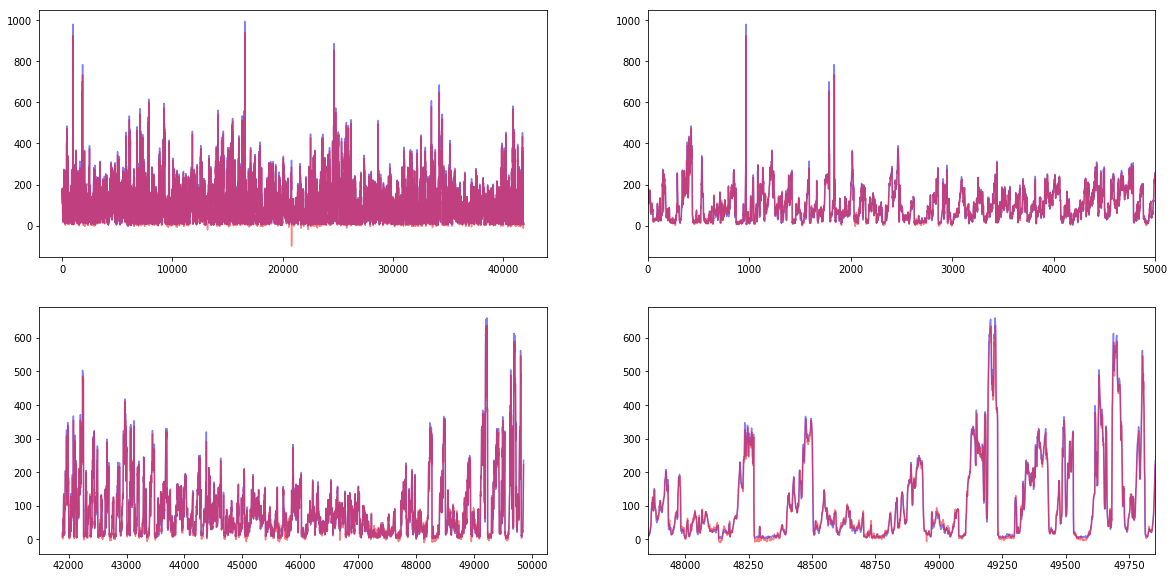

In [30]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

By adding the PM values in the previous entry (previous hour), even the simplest model can catch almost all features quite nicely. 

### Lasso model

In [52]:
# explore with LASSO model with default parameters

scaler = StandardScaler()
lasso= Lasso()
lasso_1 = Pipeline([('scaler', scaler),('lasso',lasso)])
lasso_1.fit(X_train, y_train)
y_pred_train = lasso_1.predict(X_train)
y_pred_test = lasso_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
feature_rank = pd.DataFrame({'feature':X_train.columns, 'coefficient':lasso_1.named_steps.lasso.coef_})
print(feature_rank.sort_values('coefficient',ascending=False))

0.9381772985607683 0.9585112405108204
504.0876675243859 343.4339252243386
          feature  coefficient
12         pm_1hr    85.141258
3            hour     0.930459
0            year    -0.000000
1           month    -0.000000
2             day     0.000000
4          season     0.000000
5            dewp    -0.000000
6            humi     0.000000
7            pres     0.000000
10          iprec    -0.000000
13        cbwd_NE    -0.000000
15        cbwd_SE     0.000000
8            temp    -0.084493
9   precipitation    -0.765414
14        cbwd_NW    -1.849024
11             ws    -2.289029


In [16]:
# adding PCA as a preprocessing step to decorrelate features

lasso_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('lasso', Lasso())])
lasso_2.fit(X_train, y_train)
y_pred_train = lasso_2.predict(X_train)
y_pred_test = lasso_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(lasso_2.named_steps.lasso.coef_, lasso_2.named_steps.lasso.intercept_)

0.9380157939855109 0.9581944684161716
505.40453758571726 346.0560880753419
[86.31942994  1.38102482  0.         -0.          1.27815343  0.
 -0.30977674 -0.         -2.22530842  0.          0.         -0.
 -0.56782839  1.28917724  0.          0.        ] 97.14323084512982


In [22]:
# grid search of parameter alpha to improve lasso model

parameters = {'lasso__alpha': np.arange(0.01,0.1,0.01)}
lasso_cv = GridSearchCV(lasso_2, parameters, scoring='r2',cv=3)
lasso_cv.fit(X_train, y_train)
print(lasso_cv.best_params_)
print(lasso_cv.best_score_)

{'lasso__alpha': 0.03}
0.9395171741951563


In [23]:
# update model with best parameters

lasso_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('lasso', Lasso(alpha=0.03))])
lasso_3.fit(X_train, y_train)
y_pred_train = lasso_3.predict(X_train)
y_pred_test = lasso_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(lasso_3.named_steps.lasso.coef_, lasso_3.named_steps.lasso.intercept_)

# add scores to the score table
score_table.loc['Lasso',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.9391756974828636 0.9592485492876118
495.9469591408704 337.3306613419397
[87.28942994  2.35102482  0.2973078  -0.17467904  2.24815343  0.50782943
 -1.27977674 -0.2311452  -3.19530842  0.4526597   0.76877011 -0.15210918
 -1.53782839  2.25917724  0.27693303  0.95342845] 97.14323084512982


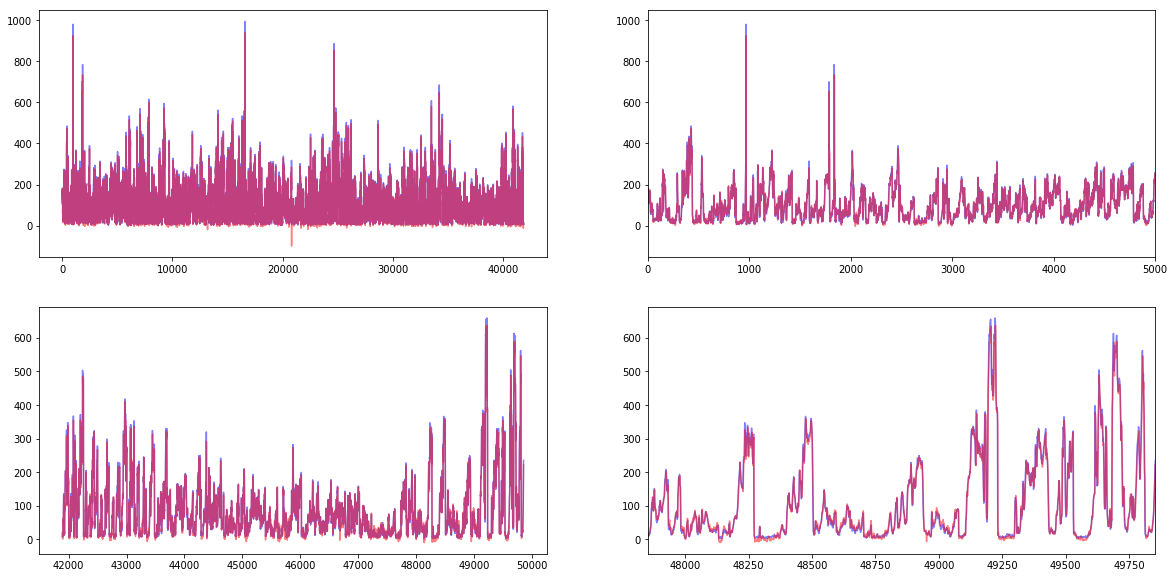

In [34]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### Ridge model

In [53]:
# explore with Ridge model with default parameter

ridge_1 = Pipeline([('scaler', StandardScaler()),('ridge',Ridge())])
ridge_1.fit(X_train, y_train)
y_pred_train = ridge_1.predict(X_train)
y_pred_test = ridge_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
feature_rank = pd.DataFrame({'feature':X_train.columns, 'coefficient':ridge_1.named_steps.ridge.coef_})
print(feature_rank.sort_values('coefficient',ascending=False))

0.9391774627836471 0.9592348282194437
495.9325652963158 337.4442410285165
          feature  coefficient
12         pm_1hr    85.069238
6            humi     2.854293
3            hour     2.230260
15        cbwd_SE     0.544400
2             day     0.378621
1           month     0.213924
8            temp     0.179025
10          iprec     0.109794
4          season     0.090493
0            year    -0.362617
13        cbwd_NE    -0.865619
7            pres    -1.468386
9   precipitation    -1.834791
11             ws    -2.740236
14        cbwd_NW    -2.868104
5            dewp    -4.110388


In [36]:
# adding PCA as a preprocessing step to decorrelate features

ridge_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('ridge', Ridge())])
ridge_2.fit(X_train, y_train)
y_pred_train = ridge_2.predict(X_train)
y_pred_test = ridge_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(ridge_2.named_steps.ridge.coef_, ridge_2.named_steps.ridge.intercept_)

0.9391774630034057 0.9592351185713849
495.93256350445677 337.4418375653111
[87.31734555  2.38096798  0.32729999 -0.20467416  2.27809905  0.53781659
 -1.30974547 -0.26113896 -3.22523143  0.48264818  0.79875104 -0.18210483
 -1.56779096  2.28912259  0.30692571  0.98340497] 97.14323084512982


In [43]:
# grid search of parameter alpha to improve Ridge model

parameters = {'ridge__alpha': np.arange(0.0001,0.002, 0.0005)}
ridge_cv = GridSearchCV(ridge_2, parameters, scoring='r2',cv=3)
ridge_cv.fit(X_train, y_train)
print(ridge_cv.best_params_)
print(ridge_cv.best_score_)

{'ridge__alpha': 0.0001}
0.9395152388624


In [44]:
# update model with best parameters

ridge_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('ridge', Ridge(alpha=0.0001))])
ridge_3.fit(X_train, y_train)
y_pred_train = ridge_3.predict(X_train)
y_pred_test = ridge_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(ridge_3.named_steps.ridge.coef_, ridge_3.named_steps.ridge.intercept_)

# add scores to the score table
score_table.loc['Ridge',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.9391774635385679 0.9592354836895954
495.9325591408705 337.4388152049955
[87.31942974  2.38102482  0.3273078  -0.20467904  2.27815343  0.53782943
 -1.30977674 -0.2611452  -3.22530842  0.4826597   0.79877011 -0.18210918
 -1.56782839  2.28917723  0.30693303  0.98342845] 97.14323084512982


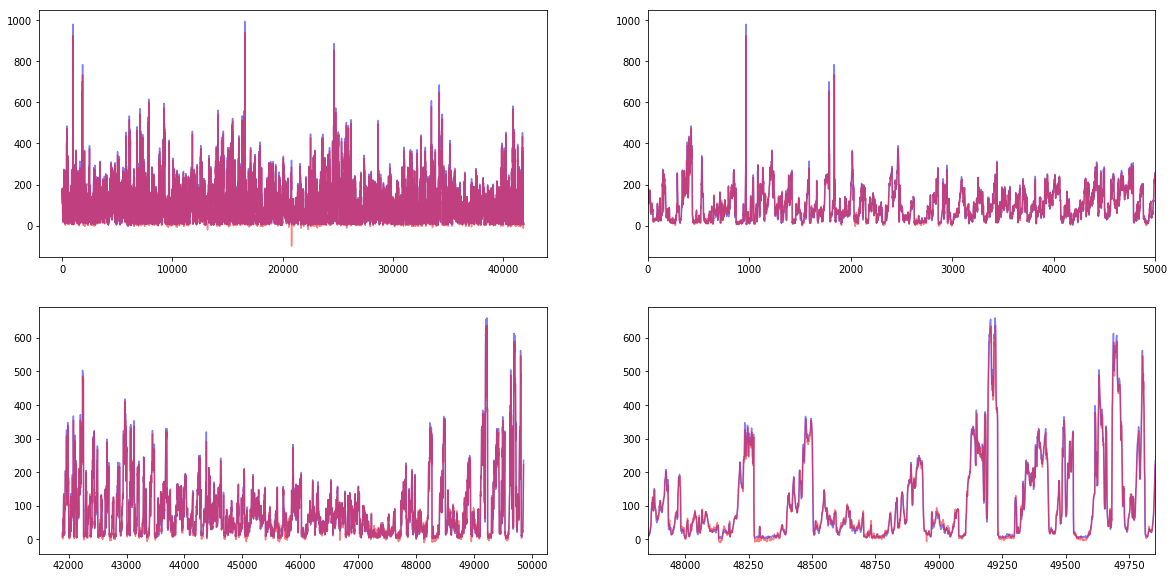

In [45]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### RandomForestRegressor model

In [46]:
# explore with RandomForestRegressor model with default parameters

rfr_1 = Pipeline([('scaler', StandardScaler()),('rfr',RandomForestRegressor())])
rfr_1.fit(X_train, y_train)
y_pred_train = rfr_1.predict(X_train)
y_pred_test = rfr_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(rfr_1.named_steps.rfr.n_features_)
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': rfr_1.named_steps.rfr.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

0.987892816657404 0.9529528857849314
98.71910591707581 389.4446424596696
16
          feature  importance
12         pm_1hr    0.944874
11             ws    0.007420
6            humi    0.006998
5            dewp    0.006553
3            hour    0.006397
7            pres    0.005823
2             day    0.005543
8            temp    0.004936
0            year    0.002864
1           month    0.002817
14        cbwd_NW    0.001688
10          iprec    0.000914
15        cbwd_SE    0.000896
9   precipitation    0.000889
4          season    0.000757
13        cbwd_NE    0.000631


In [48]:
# adding PCA as a preprocessing step to decorrelate features

rfr_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('rfr',RandomForestRegressor(n_jobs=2))])
rfr_2.fit(X_train, y_train)
y_pred_train = rfr_2.predict(X_train)
y_pred_test = rfr_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(rfr_2.named_steps.rfr.n_features_)

0.9884584664439054 0.9484110000084099
94.10693150743066 427.04127536353235
16


In [56]:
# grid search of parameter n_estimators and max_features to improve RandomForestRegressor model

parameters = {'rfr__n_estimators': np.arange(10,60,10), 'rfr__max_features':['auto','sqrt','log2']}
rfr_cv = GridSearchCV(rfr_2, parameters, scoring='r2',cv=3)
rfr_cv.fit(X_train, y_train)
print(rfr_cv.best_params_)
print(rfr_cv.best_score_)

{'rfr__max_features': 'auto', 'rfr__n_estimators': 40}
0.9289207040959846


In [57]:
# update model with best parameters

rfr_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('rfr', RandomForestRegressor(n_estimators=40, max_features='auto', n_jobs=2))])
rfr_3.fit(X_train, y_train)
y_pred_train = rfr_3.predict(X_train)
y_pred_test = rfr_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(rfr_3.named_steps.rfr.n_features_)

# add scores to the score table
score_table.loc['RandomForestRegressor',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.9913433304552351 0.9527264608194279
70.58443351329774 391.3189336081413
16


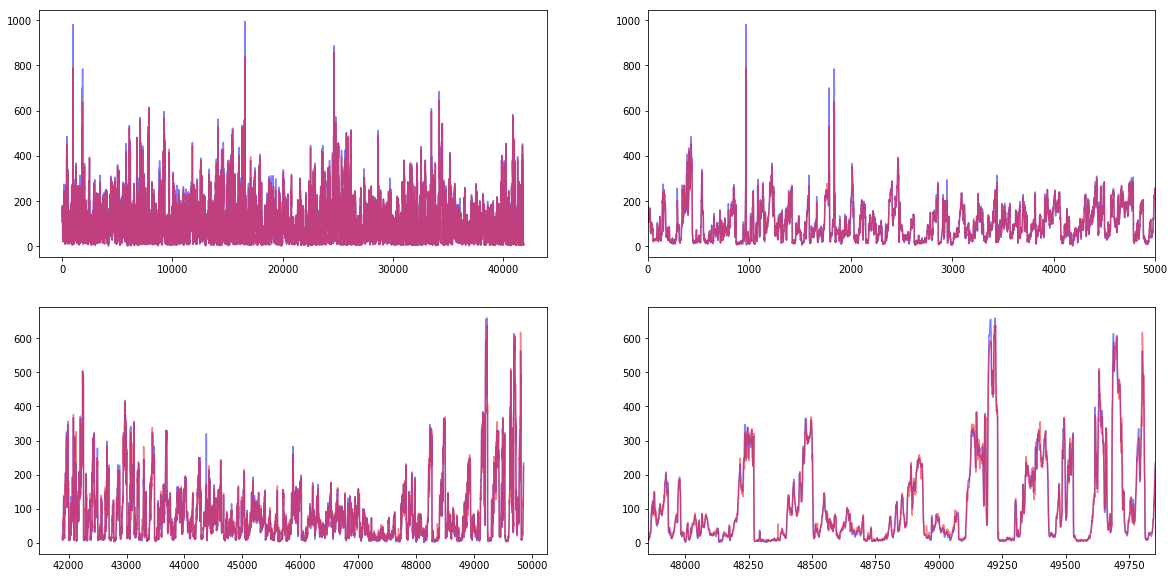

In [66]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### GradientBoostingRegressor model

In [67]:
# explore with GradientBoostingRegressor model with default parameters

gbr_1 = Pipeline([('scaler', StandardScaler()),('gbr',GradientBoostingRegressor())])
gbr_1.fit(X_train, y_train)
y_pred_train = gbr_1.predict(X_train)
y_pred_test = gbr_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(gbr_1.named_steps.gbr.train_score_)
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': gbr_1.named_steps.gbr.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

0.9489877544611468 0.96153528778383
415.94177009779787 318.4015926643704
[6744.14381303 5596.57855872 4661.83819455 3898.05287703 3276.72255426
 2769.89683361 2357.75754813 2017.51087854 1741.51001328 1516.54640183
 1334.04852172 1183.32898554 1061.72900803  961.49283522  879.93070592
  811.8027025   756.77564082  711.75497704  673.73179071  641.50244256
  615.52881461  592.56042902  573.99628705  557.48874619  542.5953102
  531.23630852  520.37100383  511.9104652   504.51760927  497.26173432
  490.88943435  485.5631873   481.27123504  476.8599464   472.91670754
  469.13950841  466.56176025  463.88158624  461.35099181  459.30646593
  457.20870251  455.15382699  453.04222431  451.49772601  449.90943747
  448.64916028  447.39902802  446.31460897  445.253292    444.05754855
  443.1575518   442.16435952  441.22448951  440.44301512  439.62193471
  438.49263081  438.09715668  437.17723058  436.4149602   435.4234423
  434.80028988  433.85095588  433.11088404  432.29408005  431.8749762
  430.5

In [68]:
# adding PCA as a preprocessing step to decorrelate features

gbr_2 = Pipeline([('pca',PCA()),('scaler', StandardScaler()),('gbr',GradientBoostingRegressor())])
gbr_2.fit(X_train, y_train)
y_pred_train = gbr_2.predict(X_train)
y_pred_test = gbr_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(gbr_2.named_steps.gbr.train_score_)

0.9494224602322477 0.9602924447048977
412.39728218134826 328.68954733669483
[6743.96607303 5599.16842843 4663.59359728 3903.49847816 3280.30711159
 2772.61504706 2361.06811487 2022.77670368 1747.98086581 1522.20852182
 1339.38781137 1190.52874789 1067.2213161   967.26115236  884.85242035
  818.1368321   762.79137294  717.99564954  681.1991351   650.24026634
  624.18198302  602.99621505  584.724154    569.71045074  556.06105821
  544.21863746  534.6769194   525.96533414  518.59949596  512.21002953
  506.36501164  501.02268703  495.77745293  491.71458773  487.23169522
  484.10877416  480.33100206  477.4115609   474.52947838  471.74016244
  469.72347394  467.56351457  465.32413866  463.229988    461.48329998
  458.29553904  456.56179846  454.43759477  453.02255982  451.51165687
  449.81809446  448.56486574  447.50841701  446.15905167  444.32634555
  443.06928857  441.86123092  440.9727745   440.0128378   439.02043715
  438.03748492  437.24377447  436.37037402  435.54125399  434.70531321
 

In [69]:
# grid search of parameter n_estimators, max_features, max_depth, learning_rate to improve GradientBoostingRegressor model

parameters = {'gbr__n_estimators': np.arange(10,100,20), 'gbr__learning_rate': [0.01, 0.05, 0.1, 0.15],'gbr__max_features':['auto','sqrt','log2'],'gbr__max_depth': np.arange(5,10,2)}
gbr_cv = GridSearchCV(gbr_2, parameters, scoring='r2',cv=3)
gbr_cv.fit(X_train, y_train)
print(gbr_cv.best_params_)
print(gbr_cv.best_score_)

{'gbr__learning_rate': 0.1, 'gbr__max_depth': 5, 'gbr__max_features': 'auto', 'gbr__n_estimators': 70}
0.9364436640853803


In [70]:
# update model with best parameters

gbr_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),
                  ('gbr', GradientBoostingRegressor(n_estimators=70, learning_rate=0.1, max_features='auto', max_depth=5))])
gbr_3.fit(X_train, y_train)
y_pred_train = gbr_3.predict(X_train)
y_pred_test = gbr_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(gbr_3.named_steps.gbr.train_score_)

# add scores to the score table
score_table.loc['GradientBoostingRegressor',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.9576037279915954 0.9595061914696769
345.6891622481584 335.19796161846284
[6704.03031705 5529.07697129 4576.04146606 3803.54865026 3175.63059966
 2666.69772145 2251.86273193 1914.83558003 1641.55511146 1419.32055354
 1237.7395212  1090.35703425  970.59455822  872.94669498  791.42063738
  725.71279786  671.27732759  625.53175157  589.12639653  559.06414676
  533.47784226  512.25818293  495.09414062  480.31212829  467.58863918
  457.22212545  447.33149696  437.7756374   430.3901689   424.63071067
  419.19167389  413.17425226  407.81006929  404.15919594  400.862676
  397.82396516  395.09603411  391.02233332  388.85041646  385.67091944
  382.85306287  380.65159791  378.71959526  375.91958448  374.35328993
  372.87260508  371.53997361  369.80149847  367.83798843  366.44849595
  365.04496594  363.34664419  362.47445429  361.31923961  360.37567816
  358.84467367  357.64196582  355.64708226  354.71553177  353.26283786
  352.24601872  351.46361288  350.36449275  349.74984704  349.31852143
  34

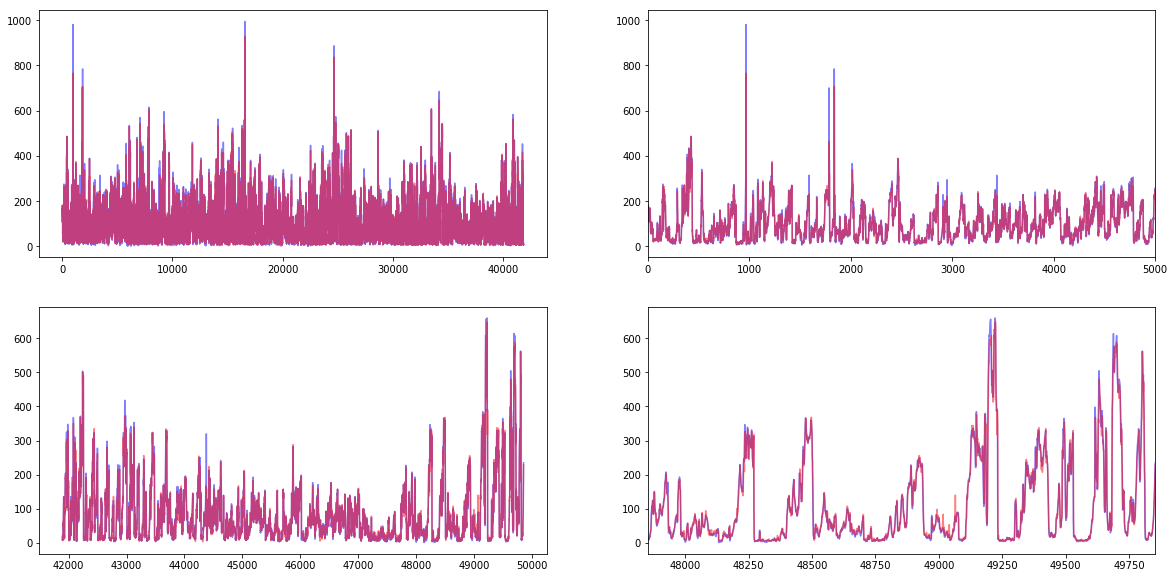

In [71]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### KNeighborsRegressor model

In [72]:
# explore with KNeighborsRegressor model with default parameters

knr_1 = Pipeline([('scaler', StandardScaler()),('knr',KNeighborsRegressor(n_jobs=2))])
knr_1.fit(X_train, y_train)
y_pred_train = knr_1.predict(X_train)
y_pred_test = knr_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)

0.9491947468804125 0.8810218232237447
414.2540029282344 984.8725960813865


In [73]:
# adding PCA as a preprocessing step to decorrelate features

knr_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('knr',KNeighborsRegressor(n_jobs=2))])
knr_2.fit(X_train, y_train)
y_pred_train = knr_2.predict(X_train)
y_pred_test = knr_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)

0.9441400128506673 0.8663575932587216
455.46910721342954 1106.259548096514


In [74]:
# grid search of parameters n_neighbors, weights to improve KNeighborsRegressor model

parameters = {'knr__n_neighbors': np.arange(1,100,10),'knr__weights':['distance','uniform']}
knr_cv = GridSearchCV(knr_2, parameters, scoring='r2',cv=3)
knr_cv.fit(X_train, y_train)
print(knr_cv.best_params_)
print(knr_cv.best_score_)

{'knr__n_neighbors': 11, 'knr__weights': 'distance'}
0.839682532141744


In [75]:
# update model with best parameters

knr_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('knr',KNeighborsRegressor(n_neighbors=11, weights='distance', n_jobs=2))])
knr_3.fit(X_train, y_train)
y_pred_train = knr_3.predict(X_train)
y_pred_test = knr_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)

# add scores to the score table
score_table.loc['KNeighborsRegressor',:] = r2_score_train, r2_score_test, mse_train, mse_test

1.0 0.8741054968565388
1.4759023564609885e-23 1042.1242744074539


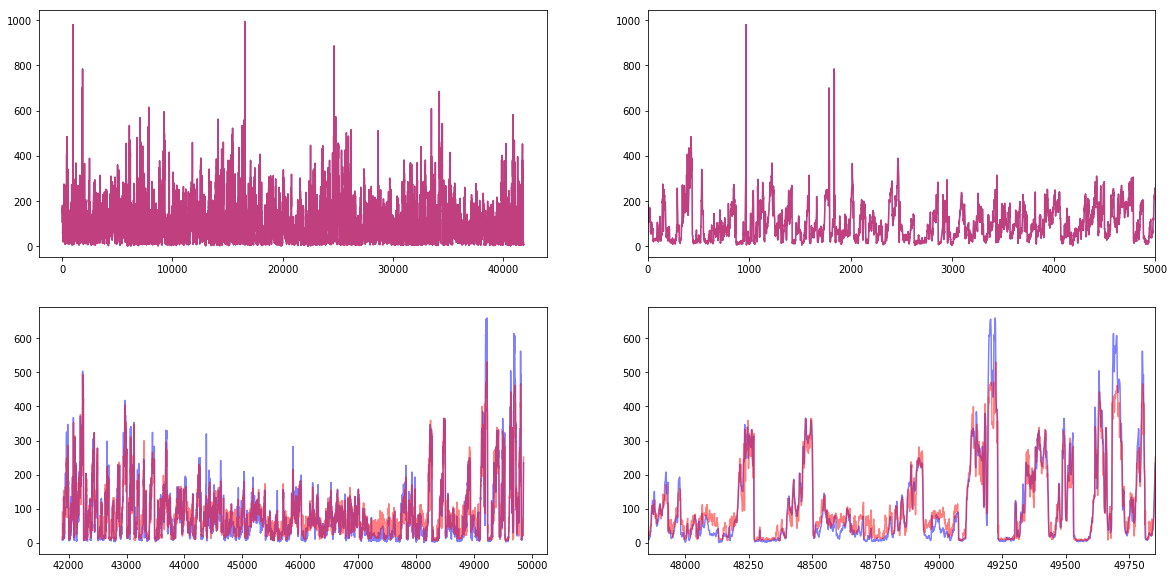

In [76]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### MLPRegressor model

In [77]:
# explore with MLPRegressor model with default parameters

mlpr_1 = Pipeline([('scaler', StandardScaler()),('mlpr',MLPRegressor())])
mlpr_1.fit(X_train, y_train)
y_pred_train = mlpr_1.predict(X_train)
y_pred_test = mlpr_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(mlpr_1.named_steps.mlpr.n_layers_, mlpr_1.named_steps.mlpr.loss_)

0.9468808385781498 0.9614148536961657
433.1210632765991 319.3985169389593
3 217.26184605150735


In [78]:
# adding PCA as a preprocessing step to decorrelate features

mlpr_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('mlpr',MLPRegressor())])
mlpr_2.fit(X_train, y_train)
y_pred_train = mlpr_2.predict(X_train)
y_pred_test = mlpr_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(mlpr_2.named_steps.mlpr.n_layers_, mlpr_2.named_steps.mlpr.loss_)

0.9472716569017409 0.9607879690267459
429.934423214316 324.58771674470387
3 215.70735673324103


In [79]:
# grid search of parameters hidden_layer_sizes, activation to improve MLPRegressor model

parameters = {'mlpr__activation': ['identity','logistic','tanh','relu'],'mlpr__hidden_layer_sizes':[(100,),(100,20),(50,100),(50,100,20)]}
mlpr_cv = GridSearchCV(mlpr_2, parameters, scoring='r2',cv=3)
mlpr_cv.fit(X_train, y_train)
print(mlpr_cv.best_params_)
print(mlpr_cv.best_score_)

{'mlpr__activation': 'relu', 'mlpr__hidden_layer_sizes': (100, 20)}
0.9433122373374249


In [81]:
# update model with best parameters

mlpr_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('mlpr',MLPRegressor(hidden_layer_sizes=(100,20), activation='relu'))])
mlpr_3.fit(X_train, y_train)
y_pred_train = mlpr_3.predict(X_train)
y_pred_test = mlpr_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(mlpr_3.named_steps.mlpr.n_layers_, mlpr_3.named_steps.mlpr.loss_)

# add scores to the score table
score_table.loc['MLPRegressor',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.9467736625526496 0.9614941762562824
433.99495120855926 318.74190395474176
4 216.79163266428188


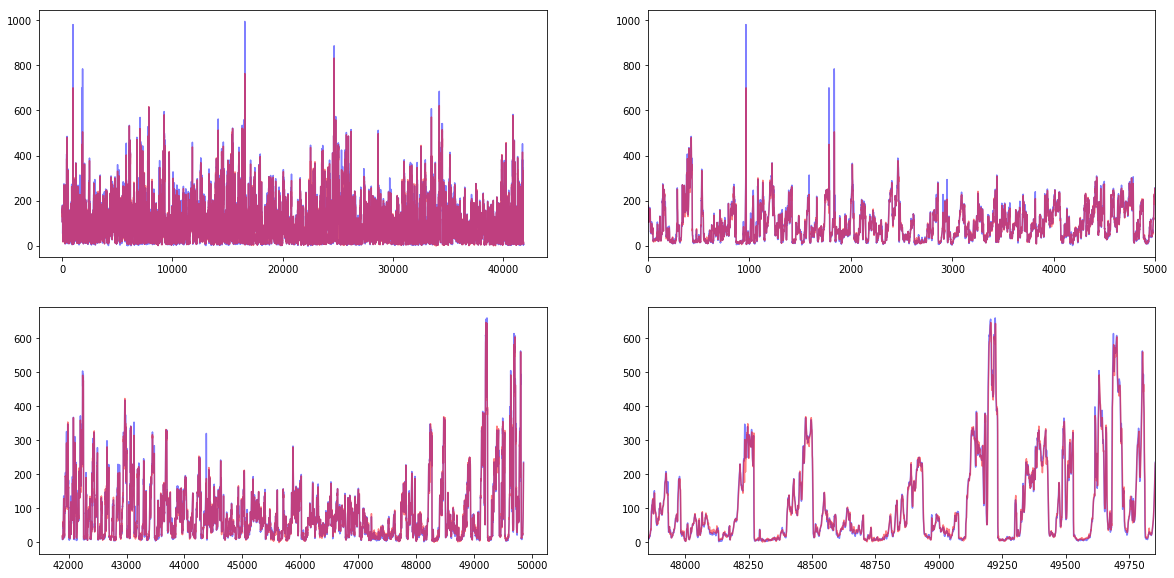

In [82]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

In [83]:
# output the summary table of scoring for different algorithms
print(score_table)

                           r2_train   r2_test   mse_train mse_test
LinearRegression           0.939177  0.959235     495.933  337.439
Lasso                      0.939176  0.959249     495.947  337.331
Ridge                      0.939177  0.959235     495.933  337.439
RandomForestRegressor      0.991343  0.952726     70.5844  391.319
GradientBoostingRegressor  0.957604  0.959506     345.689  335.198
KNeighborsRegressor               1  0.874105  1.4759e-23  1042.12
MLPRegressor               0.946774  0.961494     433.995  318.742
